## Our goal is to predict the cuisine of a recipe, given its ingredients.

In [112]:
# Widen width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [113]:
# allow plots to appear in the notebook
%matplotlib inline

In [145]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.pipeline import make_union
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [116]:
train = pd.read_json('cuisine_train.json')
new = pd.read_json('cuisine_test.json')

## Exploratory Analysis

In [38]:
train.dtypes

cuisine        object
id              int64
ingredients    object
dtype: object

In [39]:
train.loc[0, 'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [40]:
# examine the class distribution
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

## Data cleaning

In [128]:
# count the number of null values in each column
train.isnull().sum()

cuisine              0
id                   0
ingredients          0
num_ingredients      0
ingredient_length    0
ingredients_str      0
dtype: int64

## Feature Engineering

In [129]:
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    #mean length of ingredient names 
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    #Does the ingredient contain oil, coconut
    #df['contains_oil'] = np.where(any("vegetable oil" in x for x in df.ingredients), 'yes', 'no')
    #Whats the taste type - spicy, bland, sour, sweet
    #Vegetarian ingredients
    # string representation of the ingredient list
    df['ingredients_str'] = df.ingredients.astype(str)
    return(df)

In [130]:
train = make_features(train)
new = make_features(new)

In [131]:
train.head()

,cuisine,id,ingredients,num_ingredients,ingredient_length,ingredients_str
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz...",9,12.000000,"['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seaso..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y...",11,10.090909,"['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'gr..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd...",12,10.333333,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts..."
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,6.750000,"['water', 'vegetable oil', 'wheat', 'salt']"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le...",20,10.100000,"['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'b..."


In [132]:
train.shape

(39774, 6)

In [133]:
# for each cuisine, calculate the mean/describe number of ingredients
train.groupby('cuisine').num_ingredients.describe() 

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


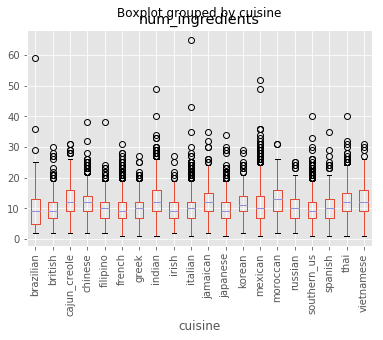

In [134]:
# box plot of number ingredients for each cuisine
train.boxplot('num_ingredients', by='cuisine', rot=90)

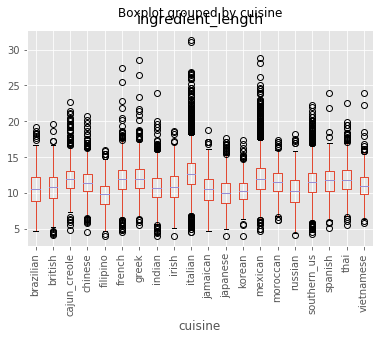

In [135]:
train.boxplot('ingredient_length', by='cuisine', rot=90)

## Extracting features from text using CountVectorizer

In [136]:
# define X and y
X = train.ingredients_str
y = train.cuisine

In [50]:
# import and instantiate CountVectorizer (with default parameters)
vect = CountVectorizer()
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [51]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 3010)

In [52]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'all', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'an', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'and', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'any', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic']


In [53]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [54]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

['a taste of thai rice noodles', 'abalone', 'abbamele', 'absinthe', 'abura age', 'acai juice', 'accent', 'accent seasoning', 'accompaniment', 'achiote', 'achiote paste', 'achiote powder', 'acini di pepe', 'ackee', 'acorn squash', 'active dry yeast', 'adobo', 'adobo all purpose seasoning', 'adobo sauce', 'adobo seasoning', 'adobo style seasoning', 'adzuki beans', 'agar', 'agar agar flakes', 'agave nectar', 'agave tequila', 'aged balsamic vinegar', 'aged cheddar cheese', 'aged gouda', 'aged manchego cheese', 'ahi', 'ahi tuna steaks', 'aioli', 'ajinomoto', 'ajwain', 'aka miso', 'alaskan king crab legs', 'alaskan king salmon', 'albacore', 'albacore tuna in water', 'alcohol', 'ale', 'aleppo', 'aleppo pepper', 'alexia waffle fries', 'alfalfa sprouts', 'alfredo sauce', 'alfredo sauce mix', 'all beef hot dogs', 'all potato purpos', 'all purpose seasoning', 'all purpose unbleached flour', 'allspice', 'allspice berries', 'almond butter', 'almond extract', 'almond filling', 'almond flour', 'almon

## Model evaluation for text features

In [147]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
nb = MultinomialNB()

In [148]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm, y, cv=5, scoring='accuracy').mean()

0.7301267156198039

- Normally, we split the data into training and testing sets **before** creating the document-term matrix. But since **`cross_val_score`** does the splitting for you, we passed it the feature matrix (**`X_dtm`**) rather than the raw text (**`X`**).
- However, that does not appropriately simulate the real world, in which your out-of-sample data will contain **features that were not seen** during model training.

**What's the solution?**

- We need a way to pass **`X`** (not **`X_dtm`**) to **`cross_val_score`**, and have the feature creation (via **`CountVectorizer`**) occur **within each fold** of cross-validation.
- We will do this by using a **`Pipeline` later**.

## Model evaluation for numerical features

In [149]:
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Null Model

In [151]:
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_pred_class = dumb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.1992156074014481

### KNN

In [152]:
knn = KNeighborsClassifier(n_neighbors=100)

In [153]:
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [154]:
# check the classification accuracy of KNN's predictions
metrics.accuracy_score(y_test, y_pred_class)

0.21932823813354788

In [155]:
# evaluate with 5-fold cross-validation (using X instead of X_train)
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21591924749538957

In [156]:
#Fit on all of the data
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [157]:
#Predicting with new data
X_new = new[feature_cols]
new_pred_class_knn = knn.predict(X_new)
new_pred_class_knn

array(['mexican', 'southern_us', 'mexican', ..., 'italian', 'mexican',
       'mexican'], dtype=object)

In [158]:
new_pred_class_knn.shape

(9944,)

In [159]:
# create a DataFrame that only contains the IDs and predicted classes for the new data
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').head()

,cuisine
id,
18009,mexican
28583,southern_us
41580,mexican
29752,mexican
35687,italian


In [169]:
# create a submission file from that DataFrame (score: 0.21742)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').to_csv('cuisine_predictions.csv')

## Searching for optimal tuning parameters using `GridSearchCV`

In [170]:

# define a "parameter grid" in which the key is the parameter and the value is a list of options to try
param_grid = {}
param_grid['n_neighbors'] = [100, 200]
param_grid
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [171]:
# run the grid search : # time the grid search using an IPython "magic function"
%time grid.fit(X, y)

CPU times: user 27.1 s, sys: 1.54 s, total: 28.6 s
Wall time: 24.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [100, 200]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [163]:
grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]

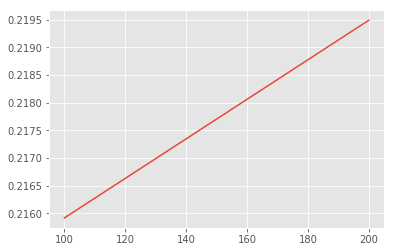

In [164]:
# line plot of K value (x-axis) versus accuracy (y-axis)
plt.style.use('ggplot')

plt.plot((100, 200), grid_mean_scores)

In [165]:
for item in (zip(grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'], grid.cv_results_['params'])):
    print(item)

(0.2159199477045306, 0.0017227056318078696, {'n_neighbors': 100})
(0.2194901191733293, 0.0018098715479753877, {'n_neighbors': 200})


In [166]:
sorted(list(grid.cv_results_.keys()))

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [167]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print()
print(grid.best_params_)
print()
print(grid.best_estimator_)

0.2194901191733293

{'n_neighbors': 200}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=200, p=2,
           weights='uniform')


In [168]:
#Predict using best param
new_pred_class_gridsearch = grid.predict(X_new)
# create a submission file from that DataFrame (score: 0.21742)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_gridsearch}).set_index('id').to_csv('cuisine_predictions_gridsearch.csv')

## Using a Pipeline for proper cross-validation

In [178]:
X = train.ingredients_str
y = train.cuisine

In [147]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")

In [148]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
nb = MultinomialNB()

In [149]:
# create a pipeline of vectorization and Naive Bayes
pipe = make_pipeline(vect, nb)

In [150]:
# examine the pipeline steps
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
          vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

Cross validation

By passing our pipeline to cross_val_score, features will be created from X (via CountVectorizer) within each fold of cross-validation.
This process simulates the real world, in which your out-of-sample data will contain features that were not seen during model training.

In [151]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7322884933790151

In [152]:
# fit the pipeline (rather than just the model)
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [162]:
# define X_new as a Series of strings
X_new = new.ingredients_str

In [163]:
# use the pipeline to make predictions for the new data
new_pred_class_pipe = pipe.predict(X_new)

In [164]:
pipe.named_steps.keys()

dict_keys(['countvectorizer', 'multinomialnb'])

In [165]:
# create a submission file (score: 0.73663)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_pipe}).set_index('id').to_csv('prediction_pipeline.csv')

## Pipeline with Grid Search

In [167]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

In [168]:
# pass the pipeline (instead of the model) to GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [169]:
# time the grid search
%time grid.fit(X, y)

CPU times: user 41.5 s, sys: 890 ms, total: 42.4 s
Wall time: 45 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), p...  vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"], 'multinomialnb__alpha': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [170]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.7476995021873586
{'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


## Efficiently searching for tuning parameters using RandomizedSearchCV

In [186]:
# for any continuous parameters, specify a distribution instead of a list of options
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['countvectorizer__min_df'] = [1, 2, 3]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'countvectorizer__min_df': [1, 2, 3],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x11d4929e8>}

In [187]:
# set a random seed for sp.stats.uniform
np.random.seed(1)

In [188]:
from sklearn.model_selection import RandomizedSearchCV

In [198]:
pipe = make_pipeline(CountVectorizer(token_pattern=r"'([a-z ]+)'"), MultinomialNB())

In [199]:
# additional parameters are n_iter (number of searches) and random_state
rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)

In [200]:
# time the randomized search
%time rand.fit(X, y)

CPU times: user 51.6 s, sys: 1.07 s, total: 52.7 s
Wall time: 53.9 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), p...  vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"], 'countvectorizer__min_df': [1, 2, 3], 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11d4929e8>},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [201]:
print(rand.best_score_)
print(rand.best_params_)

0.745436717453613
{'countvectorizer__min_df': 2, 'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.7203244934421581}


In [ ]:
# define X_new as the ingredient text
X_new = new.ingredients_str

In [ ]:
# print the best model found by RandomizedSearchCV
rand.best_estimator_

In [ ]:
# RandomizedSearchCV/GridSearchCV automatically refit the best model with the entire dataset, and can be used to make predictions
new_pred_class_rand = rand.predict(X_new)
new_pred_class_rand

In [ ]:
# create a submission file (score: 0.75342)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_rand}).set_index('id').to_csv('predictions_randomizedsearch.csv')

## Combining numerical and text features using transformer, featureunion, pipeline, cross validation and grid search

To train a model on both types of features, we need to combine them into a single feature matrix.
Because one of the matrices is sparse and the other is dense, the easiest way to combine them is by using SciPy.

Simple way: just combine them, it does not allow us to do proper cross-validation, and it doesn't integrate well with the rest of the scikit-learn workflow.

In [192]:
X_dtm = vect.fit_transform(X)
X_manual = train.loc[:, ['num_ingredients', 'ingredient_length']]
X_manual_sparse = sp.sparse.csr_matrix(X_manual)
X_dtm_manual = sp.sparse.hstack([X_dtm, X_manual_sparse])

Better way : Using Transformers and Feature Union

In [193]:
# define a function that accepts a DataFrame returns the manually created features
def get_manual(df):
    return df.loc[:, ['num_ingredients', 'ingredient_length']]

In [194]:
# create a stateless transformer from the get_manual function
get_manual_ft = FunctionTransformer(get_manual, validate=False)
get_manual_ft.transform(train).head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


In [126]:
# define a function that accepts a DataFrame returns the ingredients string
def get_text(df):
    return df.ingredients_str

In [83]:
# create and test another transformer
get_text_ft = FunctionTransformer(get_text, validate=False)
get_text_ft.transform(train).head()

0    ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seaso...
1    ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'gr...
2    ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts...
3                                                            ['water', 'vegetable oil', 'wheat', 'salt']
4    ['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'b...
Name: ingredients_str, dtype: object

In [84]:
# properly combine the transformers into a FeatureUnion
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)
X_dtm_manual = union.fit_transform(train)
X_dtm_manual.shape

(39774, 6252)

In [87]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm_manual, y, cv=5, scoring='accuracy').mean()

0.7102895106852953

In [89]:
# create a pipeline of the FeatureUnion and Naive Bayes
pipe = make_pipeline(union, nb)
# properly cross-validate the entire pipeline (and pass it the entire DataFrame)
cross_val_score(pipe, train, y, cv=5, scoring='accuracy').mean()

0.7134318388611878

### Grid Search

In [91]:
# duplicate the pipeline structure without using make_pipeline or make_union
from sklearn.pipeline import Pipeline, FeatureUnion
pipe = Pipeline([
    ('featureunion', FeatureUnion([
            ('pipeline', Pipeline([
                    ('functiontransformer', get_text_ft),
                    ('countvectorizer', vect)
                    ])),
            ('functiontransformer', get_manual_ft)
        ])),
    ('multinomialnb', nb)
])
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
%time grid.fit(train, y)
print(grid.best_score_)
print(grid.best_params_)

CPU times: user 55.5 s, sys: 1.48 s, total: 56.9 s
Wall time: 46.9 s
0.7426710916679238
{'featureunion__pipeline__countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


## Ensembling models

### Model 1: KNN model using only manually created features

In [92]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine
# use KNN with K=800
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=800)
# train KNN on all of the training data
knn.fit(X, y)
# define X_new as the manually created features
X_new = new[feature_cols]
# calculate predicted probabilities of class membership for the new data
new_pred_prob_knn = knn.predict_proba(X_new)
new_pred_prob_knn.shape
# display classes with probabilities
zip(knn.classes_, new_pred_prob_knn[0, :])
# predicted probabilities will sum to 1 for each row
new_pred_prob_knn[0, :].sum()

1.0

### Model 2: Naive Bayes model using only text features

In [202]:
# define X_new as the ingredient text
X_new = new.ingredients_str
# calculate predicted probabilities of class membership for the new data
new_pred_prob_rand = rand.predict_proba(X_new)
new_pred_prob_rand.shape

(9944, 20)

In [205]:
# calculate the mean of the predicted probabilities for all rows
new_pred_prob = pd.DataFrame((new_pred_prob_knn + new_pred_prob_rand) / 2, columns=knn.classes_)
new_pred_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.013305,0.215855,0.006912,0.02194,0.018377,0.041046,0.008991,0.037768,0.074930,0.071042,0.005103,0.037859,0.009378,0.083322,0.004380,0.014810,0.296072,0.012661,0.013751,0.012500
1,0.008752,0.011794,0.016875,0.04500,0.018143,0.024328,0.015625,0.046250,0.010630,0.070625,0.005626,0.027503,0.021875,0.066875,0.008125,0.008751,0.546973,0.007500,0.025625,0.013125
2,0.013627,0.009447,0.007219,0.02000,0.015059,0.045080,0.011783,0.029383,0.013628,0.449318,0.005651,0.038760,0.007505,0.080644,0.024697,0.008373,0.079388,0.112301,0.015626,0.012510
3,0.003125,0.004375,0.533750,0.03875,0.001875,0.023125,0.006250,0.075625,0.001250,0.051875,0.011875,0.008125,0.003125,0.107500,0.029375,0.001875,0.025000,0.007500,0.038125,0.027500
4,0.001877,0.009598,0.020083,0.02125,0.003126,0.045360,0.017502,0.013750,0.012539,0.640831,0.003754,0.007500,0.003750,0.083130,0.004377,0.003133,0.072734,0.018206,0.014375,0.003125


In [206]:
# for each row, find the column with the highest predicted probability
new_pred_class = new_pred_prob.apply(np.argmax, axis=1)
new_pred_class.head()

/Users/swetha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


0     southern_us
1     southern_us
2         italian
3    cajun_creole
4         italian
dtype: object

In [208]:
# create a submission file (score: 0.75241)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class}).set_index('id').to_csv('predicted_cuisine_ensemble.csv')

## Locating groups of similar cuisines

In [111]:
# for each cuisine, combine all of the recipes into a single string
cuisine_ingredients = train.groupby('cuisine').ingredients_str.sum()
cuisine_ingredients

cuisine
brazilian       ['ice cubes', 'club soda', 'white rum', 'lime', 'turbinado']['eggs', 'hearts of palm', 'cilantro...
british         ['greek yogurt', 'lemon curd', 'confectioners sugar', 'raspberries']['demerara sugar', 'egg whit...
cajun_creole    ['herbs', 'lemon juice', 'fresh tomatoes', 'paprika', 'mango', 'stock', 'chile pepper', 'onions'...
chinese         ['low sodium soy sauce', 'fresh ginger', 'dry mustard', 'green beans', 'white pepper', 'sesame o...
filipino        ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts...
french          ['sugar', 'salt', 'fennel bulb', 'water', 'lemon olive oil', 'grapefruit juice']['vanilla', 'mil...
greek           ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seaso...
indian          ['water', 'vegetable oil', 'wheat', 'salt']['black pepper', 'shallots', 'cornflour', 'cayenne pe...
irish           ['cooking spray', 'salt', 'black pepper', 'yukon

In [117]:
# examine the brazilian ingredients
cuisine_ingredients['brazilian'][0:500]

"['ice cubes', 'club soda', 'white rum', 'lime', 'turbinado']['eggs', 'hearts of palm', 'cilantro', 'coconut cream', 'flax seed meal', 'kosher salt', 'jalapeno chilies', 'garlic', 'cream cheese, soften', 'coconut oil', 'lime juice', 'crushed red pepper flakes', 'ground coriander', 'pepper', 'chicken breasts', 'coconut flour', 'onions']['sweetened condensed milk', 'butter', 'cocoa powder']['lime', 'crushed ice', 'simple syrup', 'cachaca']['sugar', 'corn starch', 'egg whites', 'boiling water', 'col"

In [137]:
# confirm that they match the brazilian recipes
train.loc[train.cuisine=='brazilian', 'ingredients_str'].head()

41                                            ['ice cubes', 'club soda', 'white rum', 'lime', 'turbinado']
380    ['eggs', 'hearts of palm', 'cilantro', 'coconut cream', 'flax seed meal', 'kosher salt', 'jalape...
423                                                 ['sweetened condensed milk', 'butter', 'cocoa powder']
509                                                     ['lime', 'crushed ice', 'simple syrup', 'cachaca']
724    ['sugar', 'corn starch', 'egg whites', 'boiling water', 'cold water', 'egg yolks', 'sweetened co...
Name: ingredients_str, dtype: object

In [142]:
vect = TfidfVectorizer()
cuisine_dtm = vect.fit_transform(cuisine_ingredients)
print(vect.get_feature_names()[0:100])

['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'all', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'an', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'and', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'any', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic']


In [143]:
# calculate the cosine similarity between each cuisine and all other cuisines
from sklearn import metrics
cuisine_similarity = []
for idx in range(cuisine_dtm.shape[0]):
    similarity = metrics.pairwise.linear_kernel(cuisine_dtm[idx, :], cuisine_dtm).flatten()
    cuisine_similarity.append(similarity)

In [144]:
# convert the results to a DataFrame
cuisine_list = cuisine_ingredients.index
cuisine_similarity = pd.DataFrame(cuisine_similarity, index=cuisine_list, columns=cuisine_list)
cuisine_similarity

cuisine,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
cuisine,,,,,,,,,,,,,,,,,,,,
brazilian,1.000000,0.660232,0.742324,0.580756,0.769216,0.756392,0.695692,0.687271,0.665713,0.740527,0.778320,0.555601,0.571440,0.743736,0.669009,0.706087,0.743156,0.807694,0.685539,0.653801
british,0.660232,1.000000,0.591230,0.467640,0.631356,0.859609,0.562750,0.560349,0.926682,0.632618,0.662057,0.508296,0.447177,0.560446,0.543260,0.909551,0.911271,0.604000,0.445518,0.478901
cajun_creole,0.742324,0.591230,1.000000,0.605581,0.746151,0.708849,0.688391,0.618955,0.635197,0.738159,0.780897,0.532394,0.578645,0.724877,0.649831,0.657802,0.747480,0.803637,0.590103,0.605224
chinese,0.580756,0.467640,0.605581,1.000000,0.839803,0.540446,0.496090,0.553532,0.460746,0.555504,0.635953,0.835587,0.866828,0.561837,0.505655,0.521844,0.558514,0.603526,0.755813,0.817005
filipino,0.769216,0.631356,0.746151,0.839803,1.000000,0.682939,0.607436,0.655934,0.641010,0.670628,0.792723,0.748558,0.782623,0.678302,0.614984,0.697000,0.720368,0.727409,0.741512,0.806833
french,0.756392,0.859609,0.708849,0.540446,0.682939,1.000000,0.759936,0.624868,0.837384,0.835272,0.723225,0.540279,0.502205,0.666830,0.685384,0.881173,0.862062,0.817541,0.548375,0.570925
greek,0.695692,0.562750,0.688391,0.496090,0.607436,0.759936,1.000000,0.640297,0.583675,0.859270,0.681281,0.469465,0.479835,0.696644,0.769412,0.649530,0.641229,0.837448,0.519004,0.538683
indian,0.687271,0.560349,0.618955,0.553532,0.655934,0.624868,0.640297,1.000000,0.577338,0.616211,0.734926,0.567993,0.538853,0.708621,0.795271,0.607432,0.617278,0.678865,0.627460,0.605162
irish,0.665713,0.926682,0.635197,0.460746,0.641010,0.837384,0.583675,0.577338,1.000000,0.649878,0.680914,0.494762,0.458798,0.591718,0.563303,0.892428,0.902850,0.630921,0.449931,0.481712


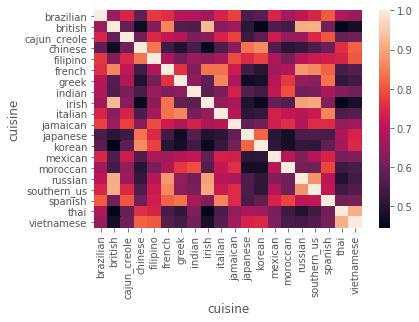

In [146]:
# display the similarities as a heatmap
%matplotlib inline
sns.heatmap(cuisine_similarity)